Useful links: https://www.tensorflow.org/tutorials/keras/classification,
https://www.tensorflow.org/api_docs/python/tf/data/Dataset

Data: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset/data

# 1.Importing libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential,layers, models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from PIL import Image
import os

# 2.Loading data

In [ ]:
from google.colab import drive

# Mounting Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Defining the base directory for the dataset
base_dir = "/content/drive/MyDrive/Eurosat"

In [ ]:
# Loading label map
label_map_path = f"{base_dir}/label_map.json"
with open(label_map_path, "r") as lm:
    label_map = json.load(lm)

print("Label Map:", label_map)

Label Map: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [ ]:
# Loading train.csv, test.csv and validation.csv
train_csv = pd.read_csv(f"{base_dir}/train.csv")
val_csv = pd.read_csv(f"{base_dir}/validation.csv")
test_csv = pd.read_csv(f"{base_dir}/test.csv")

print(val_csv.head())

   Unnamed: 0                  Filename  Label ClassName
0         258  Pasture/Pasture_1481.jpg      5   Pasture
1        2134    Forest/Forest_2638.jpg      1    Forest
2        3518   Highway/Highway_875.jpg      3   Highway
3        3048       River/River_434.jpg      8     River
4        3996  SeaLake/SeaLake_2930.jpg      9   SeaLake


# 3.Preprocessing the data

In [ ]:
# Function to load and preprocess an image
def load_image(file_path, label): # 64x64 widthxlength required for CNNs
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image, label

In [ ]:
# Function to process datasets stored in CSV files, and to map file paths and labels to their respective Python lists
def load_dataset(csv_file, base_dir, label_map): #csv_file is a pd DataFrame containing info about the dataset
    file_paths = [os.path.join(base_dir, fp) for fp in csv_file["Filename"]] # Makes a list of full file paths for all images in the dataset.
    labels = [label_map[label] for label in csv_file["ClassName"]] # Converts string labels into numeric labels using the label_map
    return file_paths, labels

train_file_paths, train_labels = load_dataset(train_csv, base_dir, label_map)
val_file_paths, val_labels = load_dataset(val_csv, base_dir, label_map)
test_file_paths, test_labels = load_dataset(test_csv, base_dir, label_map)

# 4.Creating Tensorflow datasets

In [ ]:
# Creating a Tensorflow dataset. Each (file_path, label) tuple is transformed into (image_tensor, label)
# Map the preprocessing function.
train_ds = tf.data.Dataset.from_tensor_slices((train_file_paths, train_labels))
train_ds = train_ds.map(load_image) #using a function load_image() from the previous chapter
val_ds = tf.data.Dataset.from_tensor_slices((val_file_paths, val_labels))
val_ds = val_ds.map(load_image)
test_ds = tf.data.Dataset.from_tensor_slices((test_file_paths, test_labels))
test_ds = test_ds.map(load_image)

# Shuffle, batch, and prefetch
train_ds = train_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# 5.Building a model

This section contains 4 Deep Learning models: from the very simple (with just a few layers) to the more complex one (with several convolution and pooling layers).

## 5.1.Building a simple model

Creating a model with no convolution and pooling layers.

### 5.1.1.Simple model definition

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 5.1.2.Compiling simple model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 5.1.3.Training simple model

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)

Epoch 1/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 2430s 4s/step - accuracy: 0.2417 - loss: 2.4127 - val_accuracy: 0.3200 - val_loss: 1.7742
Epoch 2/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 95s 156ms/step - accuracy: 0.3630 - loss: 1.7176 - val_accuracy: 0.3589 - val_loss: 1.6637
Epoch 3/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 141s 154ms/step - accuracy: 0.3868 - loss: 1.6536 - val_accuracy: 0.3515 - val_loss: 1.8097
Epoch 4/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 141s 152ms/step - accuracy: 0.3935 - loss: 1.6241 - val_accuracy: 0.4241 - val_loss: 1.5824
Epoch 5/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 143s 154ms/step - accuracy: 0.4196 - loss: 1.5799 - val_accuracy: 0.3839 - val_loss: 1.5735
Epoch 6/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 91s 149ms/step - accuracy: 0.4168 - loss: 1.5749 - val_accuracy: 0.4072 - val_loss: 1.6261
Epoch 7/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 91s 148ms/step - accuracy: 0.4083 - loss: 1.5729 - val_accuracy: 0.3991 - val_loss: 1.5764
Epoch 8/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 142s 149ms/step - accuracy: 0.4308 - loss

### 5.1.4.Evaluating simple model

In [ ]:
test_results = {}

test_loss, test_acc = model.evaluate(test_ds, verbose=0)

test_results["nn_model"] = test_acc*100

test_results

{'nn_model': 42.51851737499237}

In [ ]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_ds)

predictions[0]

85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step


array([2.72946477e-01, 1.77509651e-06, 1.22640274e-01, 1.80969477e-01,
       3.76639864e-03, 5.42109609e-02, 2.16712415e-01, 6.73587471e-02,
       6.47538081e-02, 1.66396238e-02], dtype=float32)

In [ ]:
print(np.argmax(predictions[0]))
print(test_labels[0])

0
0


This model gave 43% accuracy on training,validation and test datasets. The accuracz is very low, adding convolution layers.

## 5.2.Creating a CNN model

Creating a model with 1 convolution and pooling layer.

### 5.2.1.CNN model definition

In [ ]:
cnn_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=64,
                         kernel_size=(3, 3),
                         activation='relu',
                         input_shape=(64, 64, 3)),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2),
                               strides=2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])


### 5.2.2.Compling the CNN model

In [ ]:
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       7,872,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,875,722 (30.04 MB)

 Trainable params: 7,875,722 (30.04 MB)

 Non-trainable params: 0 (0.00 B)

### 5.2.3.Training the CNN model

In [ ]:
cnn_model.fit(train_ds, epochs=10,validation_data=val_ds)

Epoch 1/10
465/591 ━━━━━━━━━━━━━━━━━━━━ 7:54 4s/step - accuracy: 0.3440 - loss: 1.8674

KeyboardInterrupt: 

### 5.2.4.Evaluating the CNN model

In [ ]:
test_loss, test_acc = cnn_model.evaluate(test_ds, verbose=0)

test_results["cnn_model"] = test_acc*100

test_results

In [ ]:
probability_model_cnn = tf.keras.Sequential([cnn_model,
                                         tf.keras.layers.Softmax()])

predictions_cnn = probability_model_cnn.predict(test_ds)

predictions_cnn[0]

In [ ]:
print(np.argmax(predictions_cnn[200]))
print(test_labels[200])

8
8


This model gave 80% accuracy on training dataset, and 77% accuracy on validation and test datasets. Higher accuracy is expected, the new model with more convolution layers should be build.

## 5.3.Adding more convolutions

Creating a model with 2 convolution and pooling layers.

### 5.3.1.CNN2 model definition

In [ ]:
cnn_deep_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 5.3.2.Compiling the CNN2 model

In [ ]:
cnn_deep_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

cnn_deep_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,645,770 (6.28 MB)

 Trainable params: 1,645,770 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

### 5.3.3.Training the CNN2 model

In [ ]:
cnn_deep_model.fit(train_ds, epochs=10,validation_data=val_ds)

Epoch 1/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 1241s 2s/step - accuracy: 0.3989 - loss: 1.5666 - val_accuracy: 0.6719 - val_loss: 0.9219
Epoch 2/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 315s 456ms/step - accuracy: 0.6732 - loss: 0.9180 - val_accuracy: 0.6924 - val_loss: 0.8282
Epoch 3/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 317s 446ms/step - accuracy: 0.7391 - loss: 0.7312 - val_accuracy: 0.7646 - val_loss: 0.6284
Epoch 4/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 334s 466ms/step - accuracy: 0.7794 - loss: 0.6137 - val_accuracy: 0.6648 - val_loss: 0.9583
Epoch 5/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 279s 466ms/step - accuracy: 0.7980 - loss: 0.5593 - val_accuracy: 0.7463 - val_loss: 0.6856
Epoch 6/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 326s 472ms/step - accuracy: 0.8270 - loss: 0.4861 - val_accuracy: 0.8119 - val_loss: 0.5243
Epoch 7/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 327s 481ms/step - accuracy: 0.8453 - loss: 0.4303 - val_accuracy: 0.8133 - val_loss: 0.5231
Epoch 8/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 293s 489ms/step - accuracy: 0.8595 - l

### 5.3.4.Evaluating the CNN2 model

In [ ]:
test_results = {}

In [ ]:
test_loss, test_acc = cnn_deep_model.evaluate(test_ds, verbose=0)

test_results["cnn_deep_model"] = test_acc*100

test_results

{'cnn_deep_model': 82.25926160812378}

In [ ]:
probability_model_cnn2 = tf.keras.Sequential([cnn_deep_model,
                                         tf.keras.layers.Softmax()])

predictions_cnn2 = probability_model_cnn2.predict(test_ds)

predictions_cnn2[0]

85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step


array([0.22982743, 0.08547143, 0.08571167, 0.08547221, 0.08547139,
       0.08556349, 0.08547181, 0.08547139, 0.08548624, 0.08605283],
      dtype=float32)

In [ ]:
print(np.argmax(predictions_cnn2[100]))
print(test_labels[100])

3
3


This model gave 90% accuracy on training dataset, and 82% accuracy on validation and test datasets. This accuracy is good, but the model is overfitting.

## 5.4.Improving the model further, CNN3

This model includes 3 convolutional layers (applying convolutional filters to the input) with pooling (reducing the spatial dimentions of the input), Dropout layers (preventing overfitting by randomly dropping neurons during training), Batch Normalization layers (helping stabilize the learning process and allowing the model to train faster and generalize better), Flatten layer (transforming 2D data to 1D array), Fully connected layers (performing classification)

### 5.4.1.CNN3 model definition

In [ ]:
cnn_improved_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 5.4.2.Compiling CNN3

In [ ]:
cnn_improved_model.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

cnn_improved_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,554,186 (5.93 MB)

 Trainable params: 1,553,034 (5.92 MB)

 Non-trainable params: 1,152 (4.50 KB)

### 5.4.3.Trainging the improvrd model CNN3:

In [ ]:
cnn_improved_model.fit(train_ds, epochs=10,validation_data=val_ds)

Epoch 1/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 537s 902ms/step - accuracy: 0.9238 - loss: 0.2336 - val_accuracy: 0.6600 - val_loss: 1.4028
Epoch 2/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 533s 896ms/step - accuracy: 0.9293 - loss: 0.2074 - val_accuracy: 0.7759 - val_loss: 0.7303
Epoch 3/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 561s 895ms/step - accuracy: 0.9361 - loss: 0.1961 - val_accuracy: 0.6861 - val_loss: 1.1122
Epoch 4/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 534s 899ms/step - accuracy: 0.9312 - loss: 0.2022 - val_accuracy: 0.8007 - val_loss: 0.6262
Epoch 5/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 536s 901ms/step - accuracy: 0.9471 - loss: 0.1584 - val_accuracy: 0.7665 - val_loss: 0.8726
Epoch 6/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 570s 914ms/step - accuracy: 0.9467 - loss: 0.1628 - val_accuracy: 0.5202 - val_loss: 3.4974
Epoch 7/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 560s 910ms/step - accuracy: 0.9500 - loss: 0.1494 - val_accuracy: 0.6904 - val_loss: 1.2396
Epoch 8/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 582s 979ms/step - accuracy: 0.9560 -

In [ ]:
test_results = {}

In [ ]:
test_loss, test_acc = cnn_improved_model.evaluate(test_ds, verbose=0)

test_results["cnn_improved_model"] = test_acc*100

test_results

{'cnn_improved_model': 92.18518733978271}

In [ ]:
probability_model_cnn3 = tf.keras.Sequential([cnn_improved_model,
                                         tf.keras.layers.Softmax()])

predictions_cnn3 = probability_model_cnn3.predict(test_ds)

predictions_cnn3[100]

85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 252ms/step


array([0.08533723, 0.08533725, 0.08533721, 0.23196216, 0.08533719,
       0.08533719, 0.0853372 , 0.08533719, 0.08534016, 0.08533719],
      dtype=float32)

In [ ]:
print(np.argmax(predictions_cnn3[100]))
print(test_labels[100])

3
3


In [ ]:
# Saving the model
cnn_improved_model.save("model_cnn3_09_01_96-91-92.keras")

In [ ]:
# To load the saved model in a new notebook:
loaded_model_96 = tf.keras.models.load_model("model_cnn3_09_01_96-91-92.keras")

The accuracy of the model is 96% on training dataset, 91% on validation dataset and 92% on test dataset.

# 6.Analysing the data, misclassified by the model

211 images from the test dataset were wrongly classified. This section is aimed to analyse which classes were mostly misclassified and what were the classes they were mixed with.

In [ ]:
# Initialize pred_label
pred_label = {'id': [], 'predicted_label': []}

In [ ]:
# Loop through predictions and populate pred_label
for i in range(len(predictions_cnn3)):
    print(f"Processing index: {i}")
    predicted_label = np.argmax(predictions_cnn3[i])  # Get the index of the highest probability
    print(f"Predicted label: {predicted_label}")

    pred_label['id'].append(i)  # Add the current index to 'id'
    pred_label['predicted_label'].append(predicted_label)  # Add the predicted label

In [ ]:
# Popluate Index_Column with indices
test_csv['Index_Column'] = test_csv.index

In [ ]:
# Convert pred_label dictionary to a DataFrame
pred_label_df = pd.DataFrame(pred_label)

# Merge pred_label_df with test_csv based on IDs
test_csv = test_csv.merge(pred_label_df, left_on='Index_Column', right_on='id', how='left')

In [ ]:
# Extract rows, where true label and predicted label differ
incorrect_df = test_csv.loc[test_csv['Label']!=test_csv['predicted_label']].copy()
incorrect_df

In [ ]:
# See with which class, the class Highway (Label = 3) was mixed up mostly
incorrect_df.loc[incorrect_df['Label']==3]['predicted_label'].value_counts()

# 7.Human Parformance Benchmark

In order compare the model's accurcay to human performance for classifying satellite images the Human Performance test is needed.

There are 2700 images in test dataset. Each of them belong to one of
ten classes of land cover:

* AnnualCrop
* Forest
* HerbaceousVegatation
* Highway
* Industrial
* Pasture
* PermanentCrop
* Residential
* River
* SeaLake

The functions below visualise images and their ids. 270 images visually assesed by human and given a label (which corresponds to a class name in label map) in csv file 'test_my_label.csv'


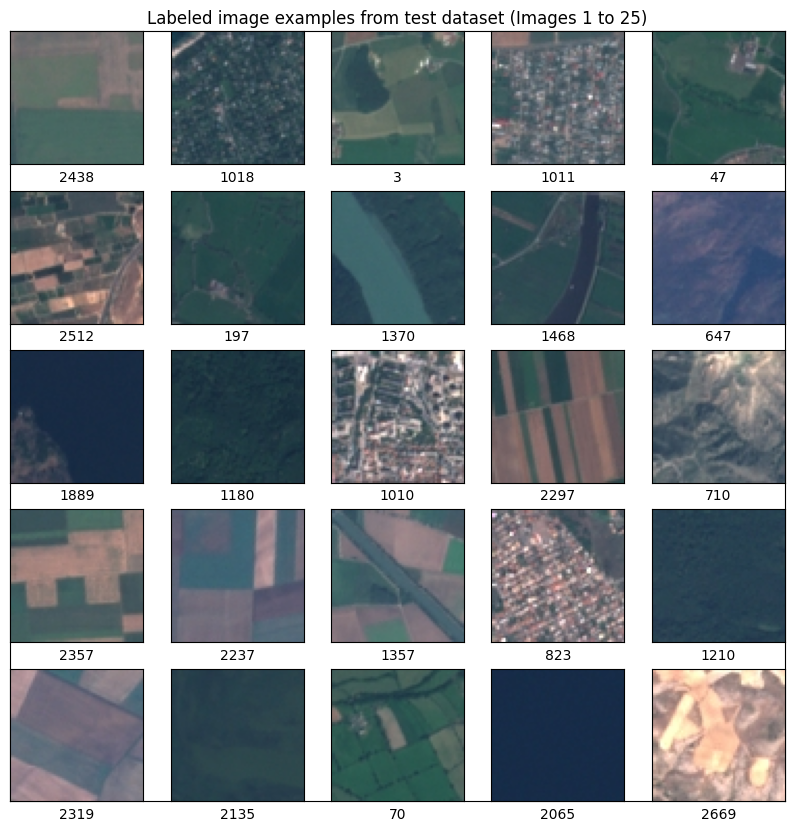

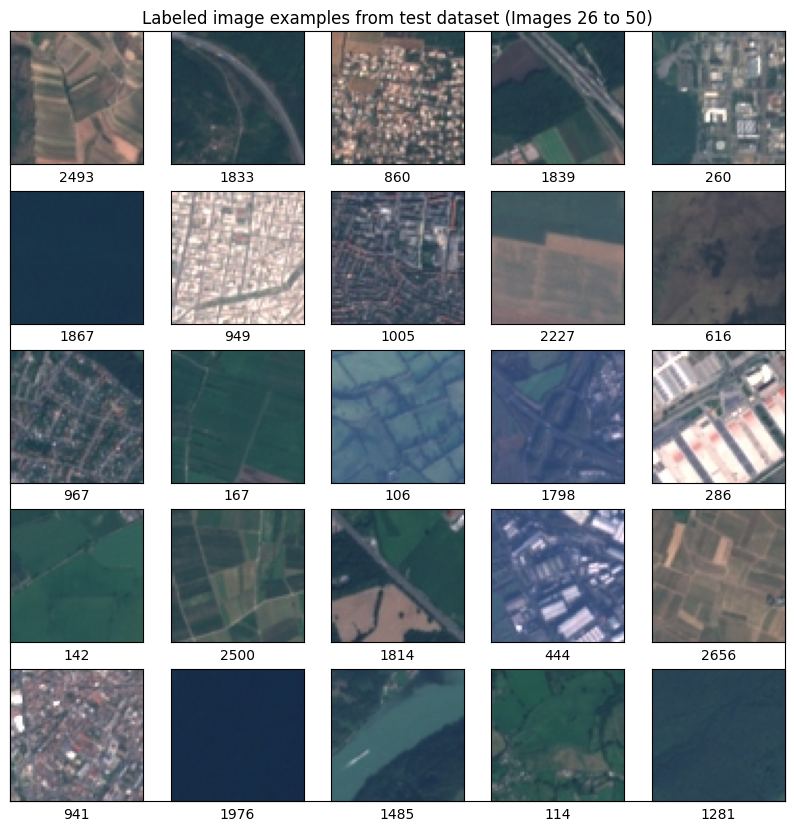

In [ ]:
# Function to visualise an image
def vis_image(file_path): # 64x64 widthxlength required for CNNs
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image

# Function to visualize images in batches
def visualize_images(start_index, end_index):
    test_example_img = []
    cl_name = []
    id_img = []

    for i in range(start_index, end_index):
        expl_img_path = os.path.join(base_dir, test_csv["Filename"].iloc[i])
        expl_img = vis_image(expl_img_path)
        test_example_img.append(expl_img)
        cl_name.append(test_csv['Label'].iloc[i])
        id_img.append(test_csv['Unnamed: 0'].iloc[i])

    plt.figure(figsize=(10, 10))
    plt.title(f"Labeled image examples from test dataset (Images {start_index + 1} to {end_index})")
    plt.xticks([])
    plt.yticks([])
    for i in range(end_index - start_index):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_example_img[i], cmap=plt.cm.binary)
        plt.xlabel(id_img[i])
    plt.show()


# Visualize the first batch of 25 images
visualize_images(0, 25)

# Visualize the next batch of 25 images (26th to 50th images)
visualize_images(25, 50)

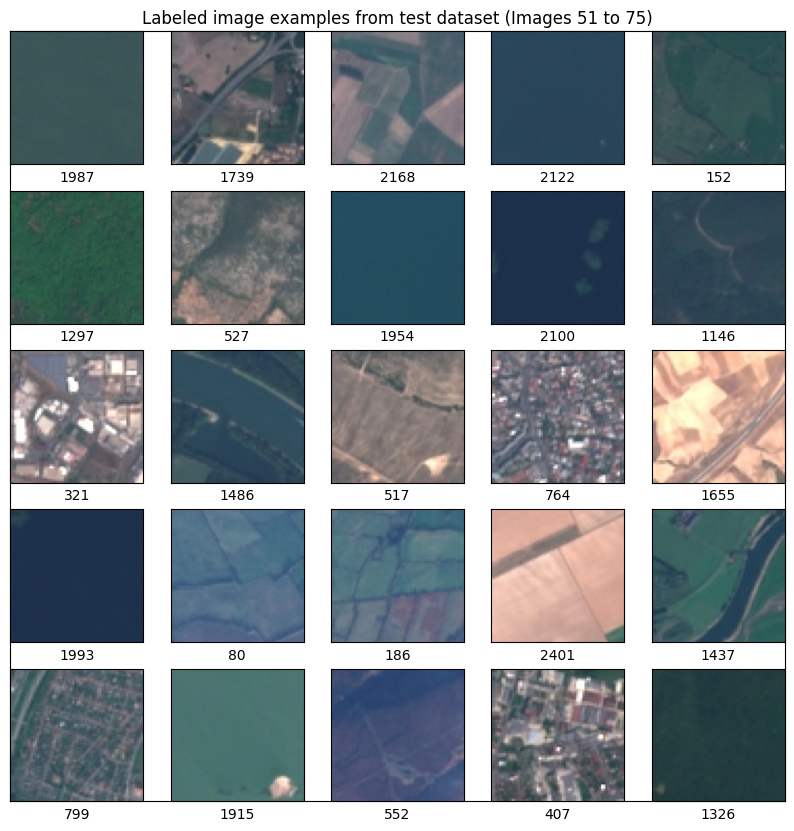

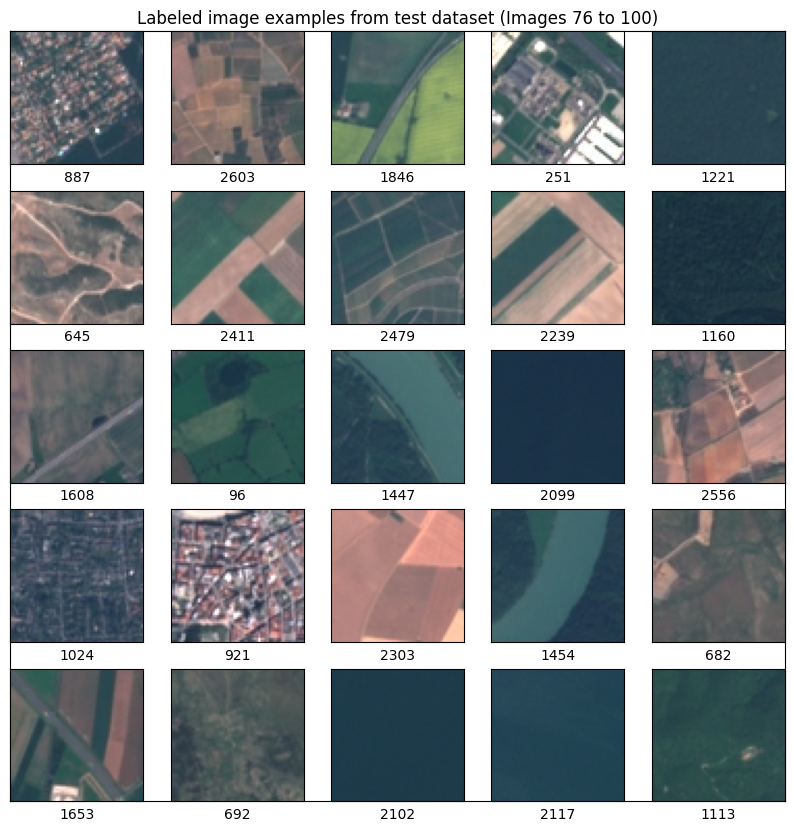

In [ ]:
# Visualize the next batch of 25 images (51th to 75th images)
visualize_images(51, 75)

# Visualize the next batch of 25 images (76th to 100th images)
visualize_images(76, 100)

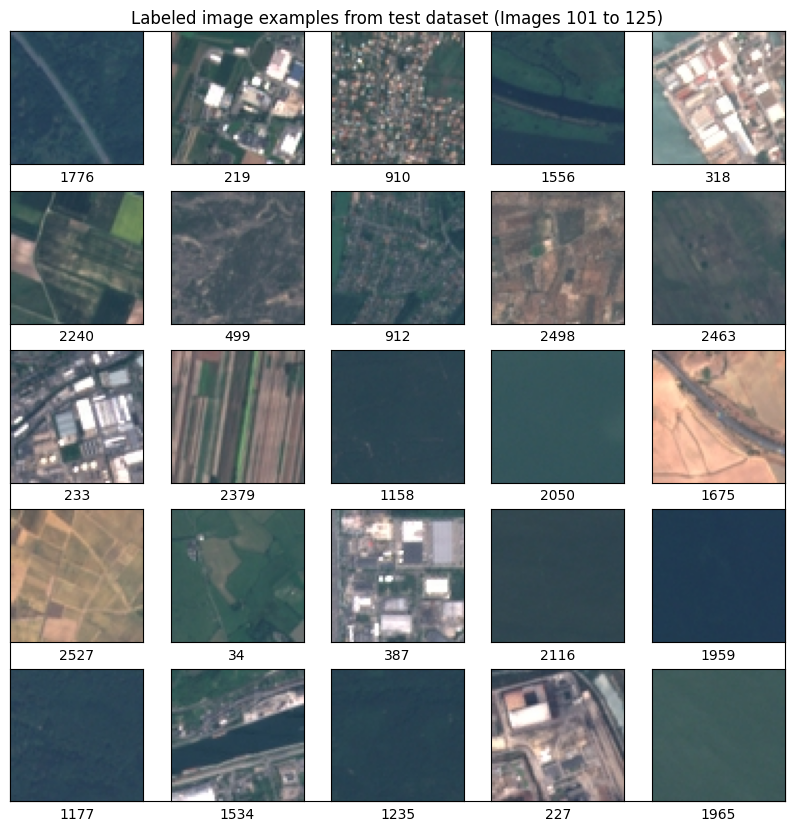

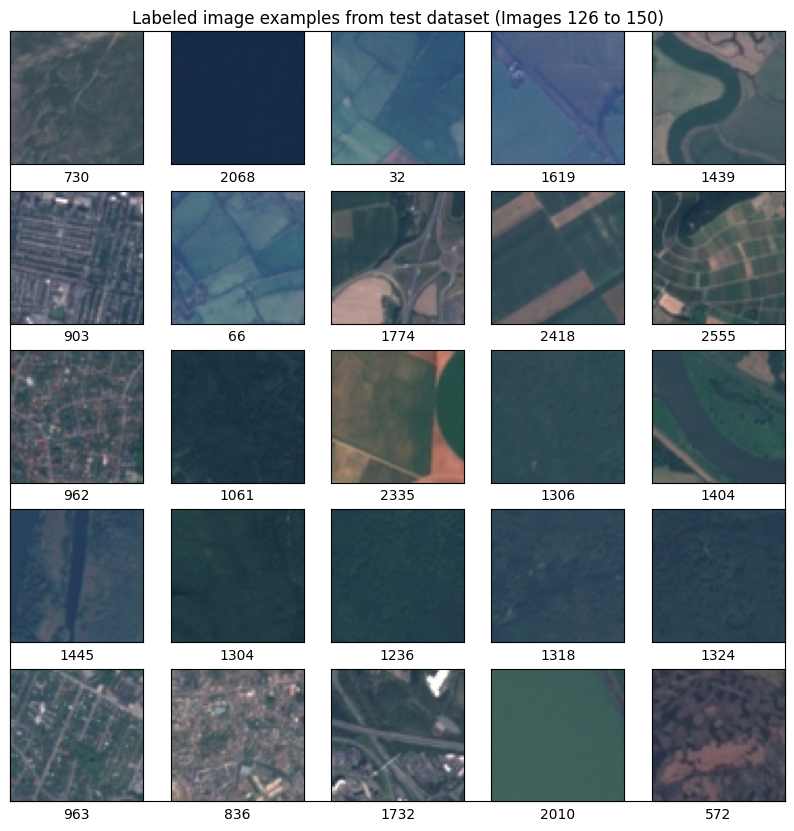

In [ ]:
# Visualize the next batch of 25 images (101th to 1250th images)
visualize_images(101, 125)

# Visualize the next batch of 25 images (126th to 150th images)
visualize_images(125, 150)

Repeat till 2700 image

# Appendix. Visualising data for presentation

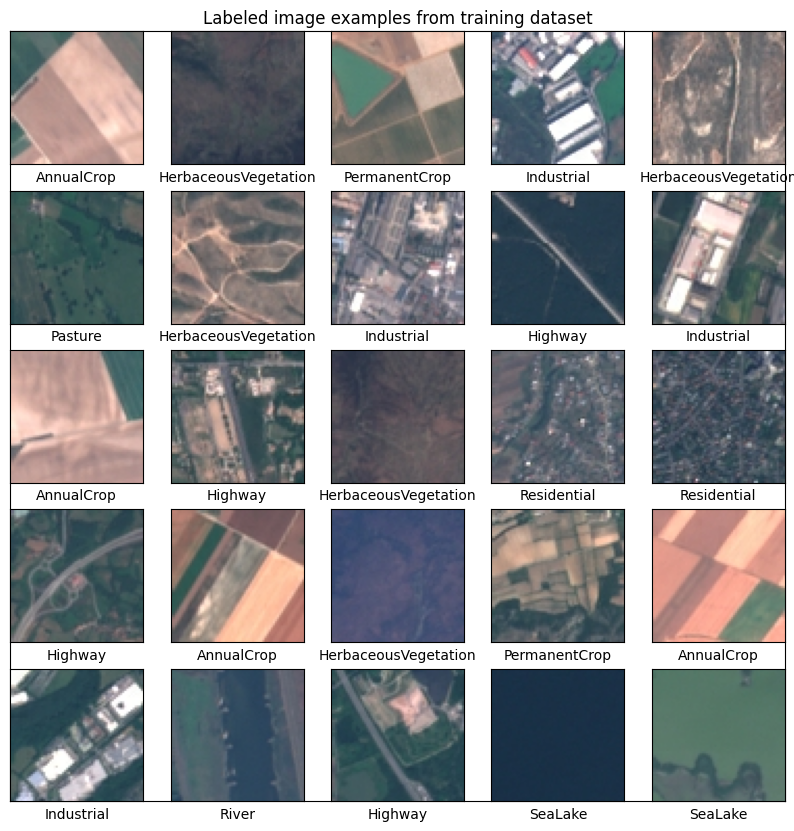

In [ ]:
# Function to visualise an image
def vis_image(file_path): # 64x64 widthxlength required for CNNs
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image

# Visualising first 25 images with labels
train_example_img=[]
cl_name = []
for i in range(25):
  expl_img_path = os.path.join(base_dir, train_csv["Filename"].iloc[i])
  expl_img = vis_image(expl_img_path)
  train_example_img.append(expl_img)
  cl_name.append(train_csv['Label'].iloc[i])

plt.figure(figsize=(10,10))
plt.title("Labeled image examples from training dataset")
plt.xticks([])
plt.yticks([])
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_example_img[i], cmap=plt.cm.binary)
    plt.xlabel(train_csv['ClassName'].iloc[i])
plt.show()

Applying Convolutional matrix:

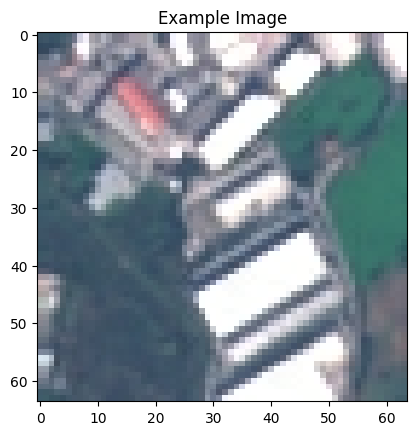

In [ ]:
# Loading example image
example_img_path = os.path.join(base_dir, train_csv["Filename"].iloc[3])
example_img = vis_image(example_img_path)

# Visualising test image
plt.imshow(example_img)
plt.title("Example Image")
plt.show()

In [ ]:
i_transformed = np.copy(example_img)
size_x = i_transformed.shape[0]
size_y = i_transformed.shape[1]

In [ ]:
filter = [ [1, 0, -1], [1, 0, -1], [1, 0, -1]]
weight  = 1

In [ ]:
for x in range(1,size_x-1):
  for y in range(1,size_y-1):
      output_pixel = 0.0
      output_pixel = output_pixel + (example_img[x - 1, y-1] * filter[0][0])
      output_pixel = output_pixel + (example_img[x, y-1] * filter[0][1])
      output_pixel = output_pixel + (example_img[x + 1, y-1] * filter[0][2])
      output_pixel = output_pixel + (example_img[x-1, y] * filter[1][0])
      output_pixel = output_pixel + (example_img[x, y] * filter[1][1])
      output_pixel = output_pixel + (example_img[x+1, y] * filter[1][2])
      output_pixel = output_pixel + (example_img[x-1, y+1] * filter[2][0])
      output_pixel = output_pixel + (example_img[x, y+1] * filter[2][1])
      output_pixel = output_pixel + (example_img[x+1, y+1] * filter[2][2])
      output_pixel = output_pixel * weight
     # if(output_pixel<0):
     #   output_pixel=0
     # if(output_pixel>255):
     #   output_pixel=255
      i_transformed[x, y] = output_pixel

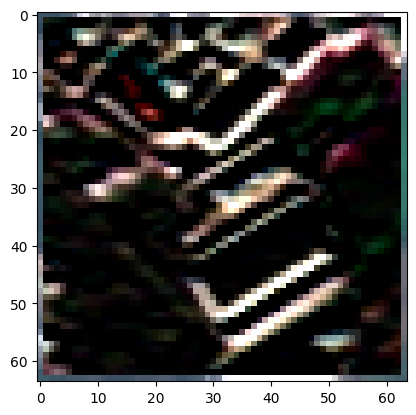

In [ ]:
# Plot the image. The size of the axes are 64 by 64
plt.gray()
plt.grid(False)
plt.imshow(i_transformed)
#plt.axis('off')
plt.show()